## Using gene descriptions and GPT to generate gene embeddings

기존 Foundation Model은 유전자 표현 Profile에서 유전자 및 세포 기능을 간접 학습합니다. 이 때문에, 광범위한 데이터 큐레이션 및 많은 리소스 투입을 요구합니다.

반면, 개별 유전자의 NCBI text description 및 GPT를 활용하여 gene embedding을 생성하고, 이 gene embedding으로 각종 task를 수행합니다.

In [ ]:
import pandas as pd
import openai
import json 
import numpy as np
import pickle

import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


#######################################
# Set your API key and data path
PATH = "./DATA/"

## OpenAI API Key
# valid for this education session only
api_key = "[API_KEY]"

# Data download from github and save to PATH

!wget -P {PATH} https://raw.githubusercontent.com/leelabsg/KOGO_OpenAI_API_Tutorial_2025/main/Session2/data/gene_embeddings_text-embedding-3-small_trimmed.pkl
!wget -P {PATH} https://raw.githubusercontent.com/leelabsg/KOGO_OpenAI_API_Tutorial_2025/main/Session2/data/NCBI_cleaned_summary_of_genes.json
!wget -P {PATH}/gene2vec https://raw.githubusercontent.com/leelabsg/KOGO_OpenAI_API_Tutorial_2025/main/Session2/data/gene2vec/test_label.txt
!wget -P {PATH}/gene2vec https://raw.githubusercontent.com/leelabsg/KOGO_OpenAI_API_Tutorial_2025/main/Session2/data/gene2vec/test_text.txt
!wget -P {PATH}/gene2vec https://raw.githubusercontent.com/leelabsg/KOGO_OpenAI_API_Tutorial_2025/main/Session2/data/gene2vec/train_label.txt
!wget -P {PATH}/gene2vec https://raw.githubusercontent.com/leelabsg/KOGO_OpenAI_API_Tutorial_2025/main/Session2/data/gene2vec/train_text.txt

## 1. Set Up OpenAI API to use embeddings

In [2]:
client = openai.OpenAI(api_key=api_key)

Embedding 모델은 OpenAI의 "text-embedding-3-small" 사용, 용도에 따라서 다른 Embedding Model로도 대체 가능

In [ ]:
EMBED_MODEL = "text-embedding-3-small"
BATCH_SIZE = 256

In [8]:
## 전 단계에서 생성한 NCBI gene summary 파일 적재
with open(f"{PATH}NCBI_cleaned_summary_of_genes.json", "r", encoding="utf-8") as f:
    summaries = json.load(f)



In [9]:
print(summaries['ANO1'])

Enables calcium activated cation channel activity; intracellular calcium activated chloride channel activity; and iodide transmembrane transporter activity. Involved in cation transport; inorganic anion transport; and positive regulation of insulin secretion involved in cellular response to glucose stimulus. Located in apical plasma membrane and nucleoplasm. [provided by Alliance of Genome Resources, Apr 2022]


In [ ]:
text_input = summaries['ANO1']
resp = client.embeddings.create(model=EMBED_MODEL, input=text_input)
print(resp.data[0].embedding)
print(len(resp.data[0].embedding))

[-0.014603609219193459, 0.005847126245498657, 0.01994500681757927, 0.06373310834169388, 0.00994409155100584, 0.0007316010305657983, 0.05045916512608528, -0.0029945923015475273, -0.05855081230401993, -0.040162768214941025, 0.02025185339152813, 0.040003661066293716, 0.017842542380094528, 0.04600420966744423, 0.03868535906076431, -0.03027549758553505, -0.023729445412755013, 0.014319492504000664, -0.02563871070742607, 0.05595966801047325, 0.006654018070548773, -0.035685084760189056, -0.021058745682239532, 0.02338850498199463, -0.0528230182826519, -0.06105104088783264, -0.0442085936665535, -0.004903858061879873, -0.022627070546150208, -0.020945098251104355, 0.03418494760990143, -0.01055778469890356, -0.01477407943457365, 0.007563192397356033, -0.007267710752785206, 0.01905856281518936, 0.03382127732038498, 0.035071391612291336, -0.027775269001722336, 0.01341031864285469, 0.0050544398836791515, -0.016365135088562965, -0.01756978966295719, -0.011552194133400917, -0.04695884510874748, -0.03043

### 2. Utilize generated gene embeddings in tasks

In [ ]:
import pickle

with open(f"{PATH}gene_embeddings_text-embedding-3-small_trimmed.pkl", "rb") as fp:
    GPT_gene_embeddings = pickle.load(fp)

In [12]:
print(GPT_gene_embeddings['ANO1'])
len(GPT_gene_embeddings)

[-0.01513383  0.00598195  0.01999665 ... -0.00338296 -0.00732832
  0.00754987]


22115

#### [Task] Gene-gene interaction prediction

본 예제에서는 생성된 gene embedding의 gene-gene interaction 예측 성능을 Gene2vec 및 무작위 embeddings에 비교해서 보여줍니다.

The input data downloaded from https://github.com/jingcheng-du/Gene2vec repo.

In [14]:
# gene gene interaction 
train_text_GGI = pd.read_csv(f'{PATH}gene2vec/train_text.txt',sep=' ', header=None)
train_label_GGI = pd.read_csv(f'{PATH}gene2vec/train_label.txt', header=None)
train_text_GGI.columns = ['gene_1','gene_2']
train_label_GGI.columns = ['label']
train_text_GGI_df = pd.concat([train_text_GGI,train_label_GGI], axis=1)

test_text_GGI = pd.read_csv(f'{PATH}gene2vec/test_text.txt',sep=' ', header=None)
test_label_GGI = pd.read_csv(f'{PATH}gene2vec/test_label.txt', header=None)
test_text_GGI.columns = ['gene_1','gene_2']
test_label_GGI.columns = ['label']
test_text_GGI_df = pd.concat([test_text_GGI,test_label_GGI], axis=1)

In [15]:
print(train_text_GGI_df.head())


   gene_1  gene_2  label
0   GPNMB    BAP1      1
1   GPR34  CARD16      0
2    ELF5   TGFB2      1
3  LILRB2    NCR2      1
4   CRMP1    DLX5      1


Featurization applied by adding embedding vectors of the two genes together

1. Gene-gene interaction with gene embeddings

In [16]:
X_array_train = []
y_array_train = []
for i, row in train_text_GGI_df.iterrows():
    if row['gene_1'] in  GPT_gene_embeddings \
        and row['gene_2'] in GPT_gene_embeddings:
        X_array_train.append(GPT_gene_embeddings[row['gene_1']]+\
                             GPT_gene_embeddings[row['gene_2']])
        y_array_train.append(row['label'])
X_array_train = np.array(X_array_train)
y_array_train = np.array(y_array_train)
X_array_train = X_array_train.reshape(X_array_train.shape[0],-1)

X_array_test = []
y_array_test = []
for i, row in test_text_GGI_df.iterrows():
    if row['gene_1'] in  GPT_gene_embeddings \
        and row['gene_2'] in GPT_gene_embeddings:
        X_array_test.append(GPT_gene_embeddings[row['gene_1']]+\
                             GPT_gene_embeddings[row['gene_2']])
        y_array_test.append(row['label'])
X_array_test = np.array(X_array_test)
y_array_test = np.array(y_array_test)
X_array_test = X_array_test.reshape(X_array_test.shape[0],-1)

In [17]:
print(X_array_train.shape, y_array_train.shape, X_array_test.shape, y_array_test.shape)
print(y_array_train[:5,])

(250692, 1536) (250692,) (20346, 1536) (20346,)
[1 0 1 1 1]


In [18]:
# Using logistic regression for the gene embeddings
lr = LogisticRegression()  # Add hyperparameters like n_estimators if needed
lr.fit(X_array_train, y_array_train)
y_pred_lr = lr.predict_proba(X_array_test)

# Computing the ROC curve with _lr suffix
fpr_lr, tpr_lr, _ = sklearn.metrics.roc_curve(y_array_test, y_pred_lr[:, 1])


<Figure size 640x480 with 0 Axes>

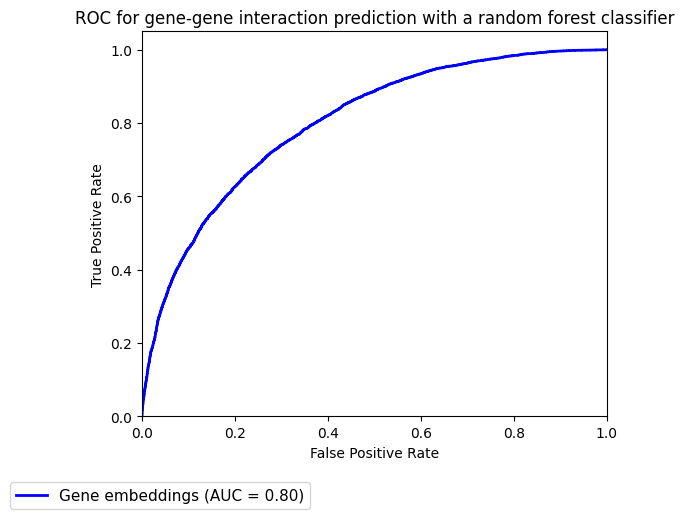

In [20]:
# Plot ROC curves
plt.figure()
# Existing Logistic Regression curves
# ... your existing plot code for Logistic Regression here ...
plt.figure(figsize=(6,5))
# Add Random Forest ROC curves
plt.plot(fpr_lr, tpr_lr, color='blue', lw=2, 
         label='Gene embeddings (AUC = %0.2f)' % (sklearn.metrics.roc_auc_score(y_array_test, y_pred_lr[:,1])))

# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for gene-gene interaction prediction with a random forest classifier')
plt.legend(loc='upper left',bbox_to_anchor=(-0.3, -0.15),fontsize=11,ncol=3)